In [85]:
import sys
sys.path.insert(1, 'model')
import model
import linear_model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

In [3]:
raw = pd.read_csv("data/covid_19_data.csv")

In [4]:
raw

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
22830,22831,05/08/2020,Wyoming,US,2020-05-09 02:32:35,644.0,7.0,0.0
22831,22832,05/08/2020,Xinjiang,Mainland China,2020-05-09 02:32:35,76.0,3.0,73.0
22832,22833,05/08/2020,Yukon,Canada,2020-05-09 02:32:35,11.0,0.0,0.0
22833,22834,05/08/2020,Yunnan,Mainland China,2020-05-09 02:32:35,185.0,2.0,182.0


In [5]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"]
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
22830,2020-05-08,US,Wyoming,644,637,7,0
22831,2020-05-08,Mainland China,Xinjiang,76,0,3,73
22832,2020-05-08,Canada,Yukon,11,11,0,0
22833,2020-05-08,Mainland China,Yunnan,185,1,2,182
22834,2020-05-08,Mainland China,Zhejiang,1268,0,1,1267


In [6]:
df_germany = ncov_df_ungrouped.loc[ncov_df_ungrouped["Country"] == "Germany", :].groupby("Date").sum()
df_germany['Country'] = 'Germany'
df_germany['Province'] = None
df_germany

,Confirmed,Infected,Deaths,Recovered,Country,Province
Date,,,,,,
2020-01-28,4,4,0,0,Germany,None
2020-01-29,4,4,0,0,Germany,None
2020-01-30,4,4,0,0,Germany,None
2020-01-31,5,5,0,0,Germany,None
2020-02-01,8,8,0,0,Germany,None
...,...,...,...,...,...,...
2020-05-04,166152,26459,6993,132700,Germany,None
2020-05-05,167007,24914,6993,135100,Germany,None
2020-05-06,168162,20987,7275,139900,Germany,None


In [7]:
df_test = pd.read_csv("../data/full-list-total-tests-for-covid-19.csv")
df_test.rename({"Cumulative total tests": "TotalTests"}, axis=1,inplace=True)
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test_germany = df_test[df_test['Entity'] == 'Germany']
df_test_germany.tail()

,Entity,Code,Date,TotalTests
440,Germany,DEU,2020-03-08,87863
441,Germany,DEU,2020-03-15,215320
442,Germany,DEU,2020-03-22,563939
443,Germany,DEU,2020-03-29,924903
444,Germany,DEU,2020-04-05,1317887


In [8]:
result = pd.merge(df_germany,
                 df_test_germany[['Date','TotalTests']],
                 on='Date',
                 how = 'left')
from numpy import isnan
result.loc[0, ('TotalTests')] = 0 if isnan(result['TotalTests'][0]) else result['TotalTests'][0]
result['TotalTests'].interpolate(method='linear',inplace=True,limit_direction='both')
result['TotalTests'] = result['TotalTests'].astype(int)
border_date = '2020-05-02'
training = result[(result['Date'] > '2020-01-01') & (result['Date'] < border_date)]
test = result[result['Date'] >= border_date]
training

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
0,2020-01-28,4,4,0,0,Germany,None,0
1,2020-01-29,4,4,0,0,Germany,None,2196
2,2020-01-30,4,4,0,0,Germany,None,4393
3,2020-01-31,5,5,0,0,Germany,None,6589
4,2020-02-01,8,8,0,0,Germany,None,8786
...,...,...,...,...,...,...,...,...
90,2020-04-27,158758,38132,6126,114500,Germany,None,1317887
91,2020-04-28,159912,36198,6314,117400,Germany,None,1317887
92,2020-04-29,161539,34672,6467,120400,Germany,None,1317887
93,2020-04-30,163009,32886,6623,123500,Germany,None,1317887


In [9]:
test

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
95,2020-05-02,164967,29155,6812,129000,Germany,None,1317887
96,2020-05-03,165664,28198,6866,130600,Germany,None,1317887
97,2020-05-04,166152,26459,6993,132700,Germany,None,1317887
98,2020-05-05,167007,24914,6993,135100,Germany,None,1317887
99,2020-05-06,168162,20987,7275,139900,Germany,None,1317887
100,2020-05-07,169430,20338,7392,141700,Germany,None,1317887
101,2020-05-08,170588,21378,7510,141700,Germany,None,1317887


In [10]:
ger_scenario = model.Scenario(training, name="Germany", places=[("Germany", None)])

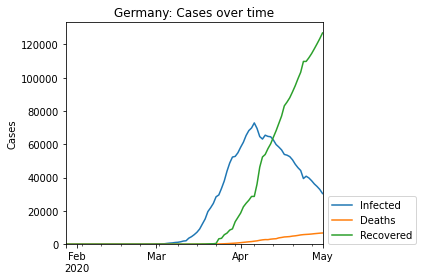

,Date,Confirmed,Infected,Deaths,Recovered
90,2020-04-27,158758,38132,6126,114500
91,2020-04-28,159912,36198,6314,117400
92,2020-04-29,161539,34672,6467,120400
93,2020-04-30,163009,32886,6623,123500
94,2020-05-01,164077,30441,6736,126900


In [11]:
ger_scenario.show_record().tail()

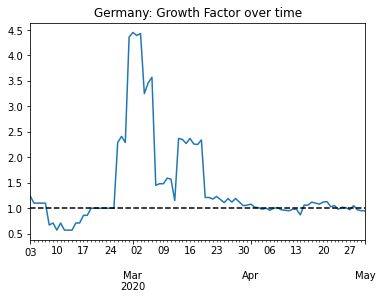

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-05-01,Crossroad,0,3


In [12]:
ger_scenario.growth_factor()

In [13]:
result.loc[result['Date'] == '2020-02-25']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
28,2020-02-25,17,3,0,14,Germany,None,61504


In [14]:
result.loc[result['Date'] == '2020-04-13']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
76,2020-04-13,130072,62578,3194,64300,Germany,None,1317887


# SIR MODEL

In [15]:
ger_scenario.set_phase(
    start_dates=["20Mar2020", "1Apr2020","13Apr2020"],
    population=82790000
)

,start_date,end_date,population
1st,20Mar2020,31Mar2020,82790000
2nd,1Apr2020,12Apr2020,82790000
3rd,13Apr2020,-,82790000


In [16]:
ger_scenario.estimate(model.SIR)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Total: 0 min 22 sec.


In [17]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,rho,sigma,Rt,score,1/beta [day],1/gamma [day]
1st,20Mar2020,31Mar2020,82790000,1093,0.119697,0.028029,4.27,0.387431,6,27
2nd,1Apr2020,12Apr2020,82790000,1093,0.060590,0.050769,1.19,0.073209,12,14
3rd,13Apr2020,-,82790000,1093,0.032491,0.061101,0.53,0.019351,23,12


../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


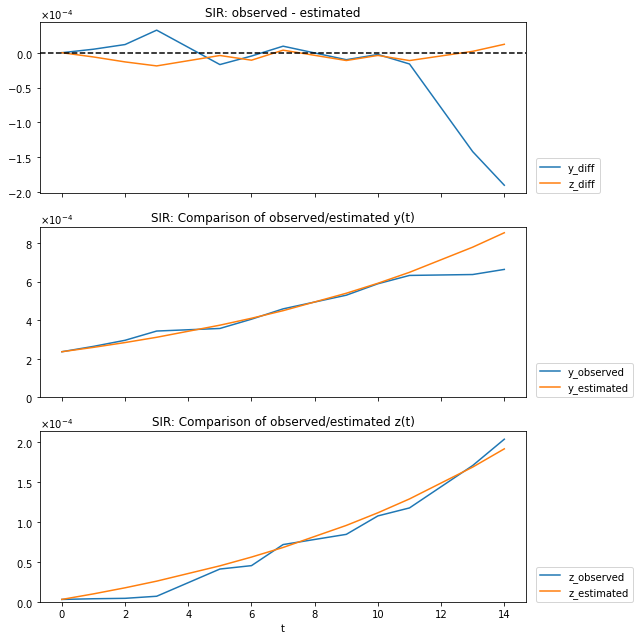

In [18]:
ger_scenario.accuracy_graph(phase_n=1)

../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


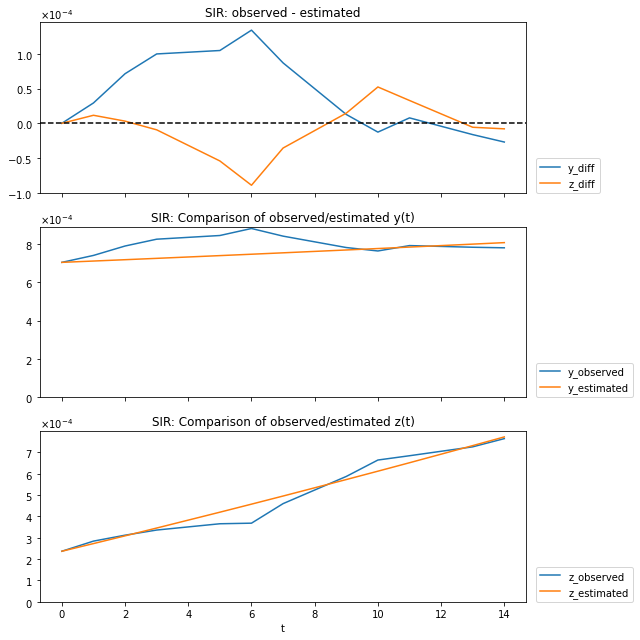

In [19]:
ger_scenario.accuracy_graph(phase_n=2)

../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


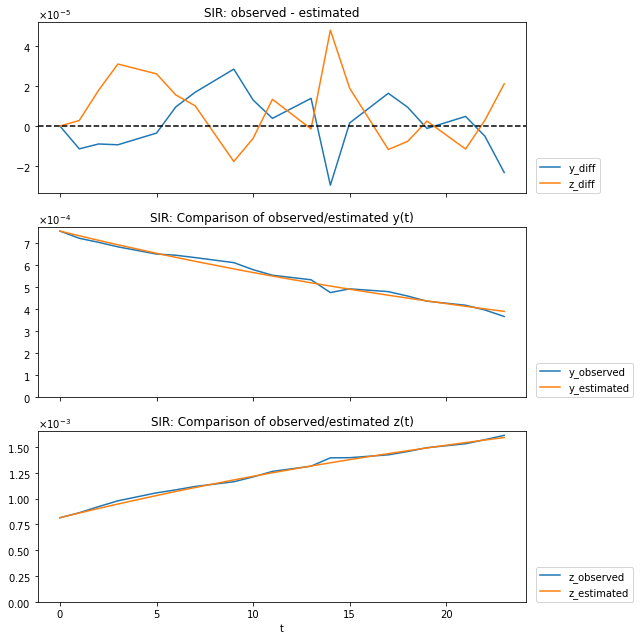

In [20]:
ger_scenario.accuracy_graph(phase_n=3)

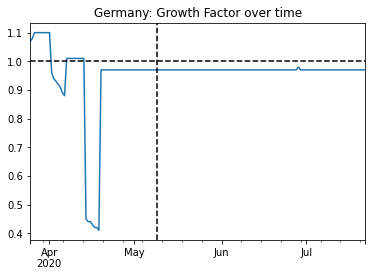

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-21 17:19:00,Stopping,0,131


In [21]:
ger_scenario.growth_factor(days_to_predict=100)

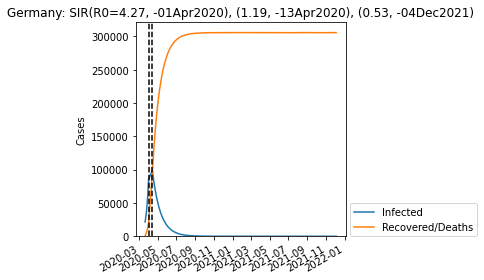

In [22]:
df_sir = ger_scenario.predict(days=600)

In [23]:
df_sir.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered/Deaths
Time,,,
2020-05-02 06:21:00,82538747,48376,202875
2020-05-03 00:34:00,82537200,47005,205794
2020-05-03 18:47:00,82535695,45671,208632
2020-05-04 13:00:00,82534233,44375,211391
2020-05-05 07:13:00,82532811,43115,214073
2020-05-06 01:26:00,82531429,41890,216680
2020-05-06 19:39:00,82530086,40699,219213
2020-05-07 13:52:00,82528781,39542,221675
2020-05-08 08:05:00,82527513,38418,224067
